## Single scale input vs. Multi-scale input vs. Gated multi-scale input

In [1]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.metrics_plot import metrics_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator


### 1. Calculate metrics (miou/oa/prod/user) for all test site scenes (only for new method).

In [4]:
path_testsite_wat = glob(config.root_proj + '/data/dset/s1_water_test_gscales/*')
path_testsite_wat.sort()
path_testsite_truth = glob(config.root_proj + '/data/dset/s1_truth/*0?_wat*.tif')
path_testsite_truth.sort()


In [6]:
oa, miou, prod, user = [], [], [], []
for idx in range(7):
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat, wat_info = readTiff(path_testsite_wat[idx])
    oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
    miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
    oa.append(float(format(oa_i, '.4f'))), miou.append(float(format(miou_i, '.4f')))
    prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

oa_m, miou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(miou), '.4f'))
prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))



In [7]:
print('oa:', oa)
print('miou:', miou)
print('prod:', prod)
print('user:', user)
print('oa_mean:', oa_m, 'miou_mean:', miou_m, 'prod_mean:', prod_m, 'user_mean:', user_m)


oa: [0.9939, 0.9856, 0.9726, 0.9492, 0.9971, 0.992, 0.9973]
miou: [0.9513, 0.879, 0.9039, 0.4841, 0.9683, 0.9669, 0.9923]
prod: [0.9895, 0.9163, 0.9233, 0.5353, 0.9941, 0.9934, 0.9964]
user: [0.961, 0.9558, 0.9772, 0.8352, 0.9739, 0.9732, 0.9959]
oa_mean: 0.984 miou_mean: 0.878 prod_mean: 0.9069 user_mean: 0.9532


### 2. Comparison among methods (plot smoothed metric for one test)

In [11]:
## 1. Model name and the selected metric
model_name = ['model_single_test_1', 'model_scales_test_1', 'model_gscales_test_1']
# metric_name = 'val_miou'
path_metrics_single = config.root_proj + '/model/pretrained/model_single_test/' + model_name[0] + '_metrics.csv'
path_metrics_scales = config.root_proj + '/model/pretrained/model_scales_test/' + model_name[1] + '_metrics.csv'
path_metrics_gscales = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_single = pd.read_csv(path_metrics_single)
metrics_scales = pd.read_csv(path_metrics_scales)
metrics_gscales = pd.read_csv(path_metrics_gscales)
metrics_single.head()


,tra_loss,tra_miou,val_loss,val_miou
0,0.551018,0.590602,0.475986,0.401644
1,0.525913,0.627190,0.220254,0.821495
2,0.431118,0.765862,0.328354,0.622544
3,0.442150,0.741080,0.212737,0.817668
4,0.430994,0.752727,0.282373,0.684725


In [12]:
### metrics smooth
metrics_single_smooth_x, metrics_single_smooth_y = smooth(metrics_single['val_miou'].to_numpy(), num_sam=20)
metrics_scales_smooth_x, metrics_scales_smooth_y = smooth(metrics_scales['val_miou'].to_numpy(), num_sam=20)
metrics_gscales_smooth_x, metrics_gscales_smooth_y = smooth(metrics_gscales['val_miou'].to_numpy(), num_sam=20)


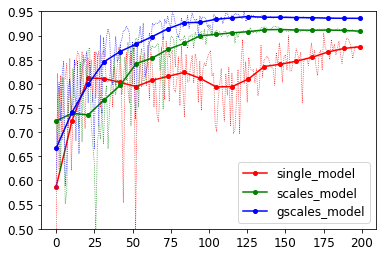

In [13]:
plt.rcParams.update({'font.size': 12})
color = ['red', 'green', 'blue']
plt.plot(metrics_single['val_miou'], color=color[0], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_single_smooth_x, metrics_single_smooth_y, color=color[0], \
            marker='o', markerfacecolor=color[0], markersize=4, linewidth=1.5, label= 'single_model')
plt.plot(metrics_scales['val_miou'], color=color[1], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_scales_smooth_x, metrics_scales_smooth_y, color=color[1], \
            marker='o', markerfacecolor = color[1], markersize=4, linewidth = 1.5,label= 'scales_model')

plt.plot(metrics_gscales['val_miou'], color=color[2], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_gscales_smooth_x, metrics_gscales_smooth_y, color=color[2], \
            marker='o', markerfacecolor=color[2], markersize=4, linewidth = 1.5, label= 'gscales_model')
plt.ylim(top=0.95, bottom=0.5)
plt.legend()


### 3. Comparison among methods (plot metric line with confidence interval)


In [ ]:
### metrics path
dir_metric_gscales = config.root_proj + '/model/pretrained/model_gscales_test'
paths_metric_gscales = glob(dir_metric_gscales + '/*metrics*')
dir_metric_scales = config.root_proj + '/model/pretrained/model_scales_test'
paths_metric_scales = glob(dir_metric_scales + '/*metrics*')
dir_metric_single = config.root_proj + '/model/pretrained/model_single_test'
paths_metric_single = glob(dir_metric_single + '/*metrics*')


### Concat metrics obtained by different iteration

In [ ]:
metrics_gscales = metrics_merge(paths_metric_gscales, new_col='i_test', sam=5)
metrics_scales = metrics_merge(paths_metric_scales, new_col='i_test', sam=5)
metrics_single = metrics_merge(paths_metric_single, new_col='i_test', sam=5)
metrics_models = metrics_merge([metrics_single, metrics_scales, metrics_gscales], new_col='i_model')

print(metrics_models.head())
print('gscales model: ',metrics_gscales.shape)
print('models:', metrics_models.shape)


   tra_loss  tra_miou  val_loss  val_miou  epoch  i_test  i_model
0  0.578091  0.575887  0.395957  0.507823      1       1        1
1  0.429618  0.770328  0.203040  0.842102      6       1        1
2  0.425312  0.769982  0.236015  0.796362     11       1        1
3  0.419432  0.776269  0.206365  0.857890     16       1        1
4  0.439303  0.741113  0.228727  0.860664     21       1        1
gscales model:  (480, 6)
models: (1320, 7)


In [ ]:
### change the column name and the corresponding values
metrics_models_ = metrics_models.rename(columns={'i_model': 'Model'})
metrics_models_['Model'] = metrics_models_['Model'].replace([1], 'Single scale')
metrics_models_['Model'] = metrics_models_['Model'].replace([2], 'Multiple scales')
metrics_models_['Model'] = metrics_models_['Model'].replace([3], 'Gated multiple scales')


,tra_loss,tra_miou,val_loss,val_miou,epoch,i_test,Model
0,0.578091,0.575887,0.395957,0.507823,1,1,Single scale
1,0.429618,0.770328,0.203040,0.842102,6,1,Single scale
2,0.425312,0.769982,0.236015,0.796362,11,1,Single scale
3,0.419432,0.776269,0.206365,0.857890,16,1,Single scale
4,0.439303,0.741113,0.228727,0.860664,21,1,Single scale
...,...,...,...,...,...,...,...
1315,0.345231,0.934197,0.149663,0.934984,176,12,Gated multiple scales
1316,0.347505,0.917044,0.150075,0.934675,181,12,Gated multiple scales
1317,0.341561,0.932212,0.149814,0.935083,186,12,Gated multiple scales
1318,0.342612,0.930314,0.149736,0.935411,191,12,Gated multiple scales


### Plot epoch-val_miou figure.

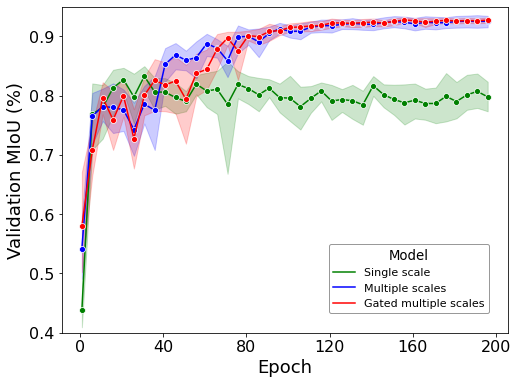

In [ ]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=95, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.47, -0.21, 0.5, 0.5))
ax.set_ylim(top=0.95, bottom=0.4)
y_major_locator=MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax.xaxis.set_major_locator(x_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/miou_methods_compare.png', bbox_inches='tight')


### Plot epoch-val_loss figure.

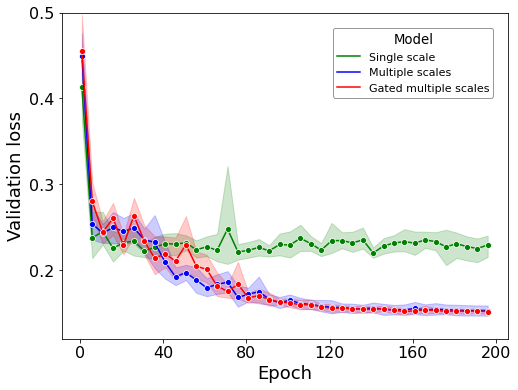

In [ ]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                hue='Model', palette=colors, marker='o', \
                ci=95, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.48, 0.47, 0.5, 0.5))
ax.set_ylim(top=0.5, bottom=0.12)
y_major_locator=MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax.xaxis.set_major_locator(x_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/loss_methods_compare.png', bbox_inches='tight')

